# Global Mean EOF Analysis
Liam Kirkpatrick
ATM 552, Assignment 5
February 4, 2024

## Introduction

This code is modeled after Dennis Hartman's script on github (https://github.com/dennislhartmann/Objective_Analysis/tree/main).

## Import Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
from scipy.io import loadmat
from scipy.interpolate import griddata
import scipy.signal as sig
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import netCDF4 as nc
from cartopy import config
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## User Inputs

This should be the only place we need to change things for the rest of the script

In [2]:
if False:
    #  Global domain
    lat1=88.
    lat2=-88.
    lon1=0.
    lon2=360.

if True:
    # Traditional PDO region
    lat1=65.
    lat2=20.
    lon1=120.
    lon2=260.
    
# set years to begin and end for climatology
yrbeg = 1950
yrend = 2023

#set the years for eof analysis
yra = yrbeg
yrb = yrend

# central longitude for Robinson maps
cent_lon = -160.   

# behind the scenes bookkeeping on year selection
iyr1 = (yrbeg-1854)*12
iyr2 = (yrend - 1854 + 1)*12

# choices on removal
rem_globmean = True  # removes global mean anomaly from each grid cell
rem_ann = True    # removes annual cycle from each grid cell


In [3]:
## Import Data

# open using xarray
ds_disk = xr.open_dataset('data/sst.mnmean.nc') 
sst = ds_disk.sst   # not here prcp is actually sst
lon = ds_disk.lon
lat = ds_disk.lat

# uncomment next line to see data format.
#ds_disk

## Clean up Data

In [4]:
# extend longitude array
lonp = np.empty(len(lon)+1)
lonp[0:len(lon)] = lon
lonp[len(lon)]= lon[len(lon)-1]+lon[1]-lon[0]

# Calculate SST Mean
sstm = np.nanmean(sst,0)

# Here we are adding cyclic continuity to SST, so it plots without gaps
sstmp = np.empty([len(lat),len(lon)+1])
sstmp[:,0:len(lon)]= sstm
sstmp[:,len(lon+1)]= sstm[:,0]
xx = sstmp[:,0]
print('max sst',np.max(sstmp))
print('xx ',np.shape(xx))   #  This is likely NaN

# clip out years I want to consider
sst1 = sst[iyr1:iyr2,:,:]
print('sst clipped shape ',np.shape(sst))

max sst nan
xx  (89,)
sst clipped shape  (2041, 89, 180)


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_95702/223043069.py:7: RuntimeWarning: Mean of empty slice
  sstm = np.nanmean(sst,0)


## Make Grand Mean SST Plot

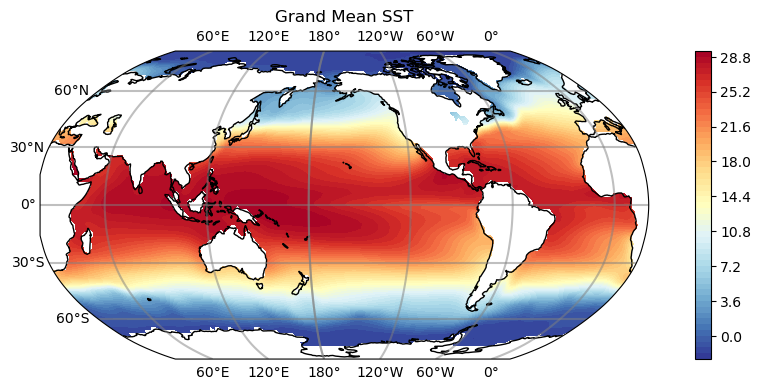

sst type  <class 'xarray.core.dataarray.DataArray'>


In [5]:
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu_r'

# make figure
plt.figure(figsize=(12, 4), dpi=100)

# set up axis. Use cent_lon set above
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')

# add color for sst
plt.contourf(lonp, lat, sstmp, 60, cmap=col_mapc,
             transform=ccrs.PlateCarree())

# Housekeeping
plt.title('Grand Mean SST')
ax.coastlines()
plt.grid()
plt.colorbar()
plt.show()
print('sst type ',type(sst))

## Remove Annual Cycle

Here we remove the annual cycle, deleting the influence of seasonality from the dataset

In [6]:
sstx = xr.DataArray.to_numpy(sst1)  # transition to numpy space
latx=len(lat) 
lonx=len(lon)
print('latx ',type(latx))
print('sst shape ',np.shape(sstx))
print('type sst ',type(sstx))
sts = np.shape(sstx)
yrmx = int(sts[0]/12)
print('sts[0] = ',sts[0],'yrmx = ',yrmx)

# Now remove annual cycle from prcp
sstx = np.reshape(sstx,(yrmx,12,latx,lonx))
print('sstx shape ',np.shape(sstx))
sstm = np.nanmean(sstx,0)
print('sstm ',np.shape(sstm))
sstmx = np.max(sstm)
print('sstmx ',sstmx)


if rem_ann:
    # subtract mean from each month
    for i in range(0,yrmx):
        sstx[i,:,:,:] = sstx[i,:,:,:]-sstm

latx  <class 'int'>
sst shape  (888, 89, 180)
type sst  <class 'numpy.ndarray'>
sts[0] =  888 yrmx =  74
sstx shape  (74, 12, 89, 180)
sstm  (12, 89, 180)
sstmx  nan


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_95702/2813497442.py:14: RuntimeWarning: Mean of empty slice
  sstm = np.nanmean(sstx,0)


## Plot a monthly mean

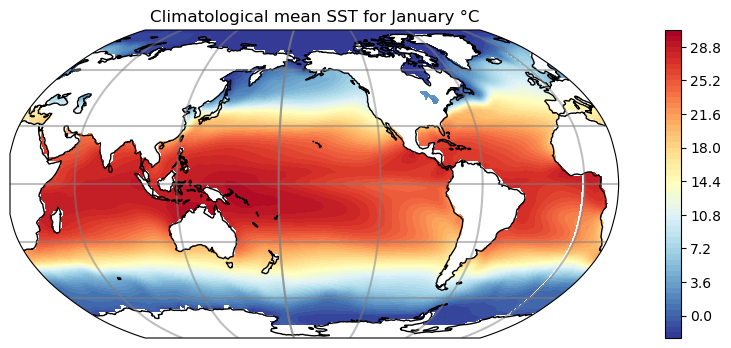

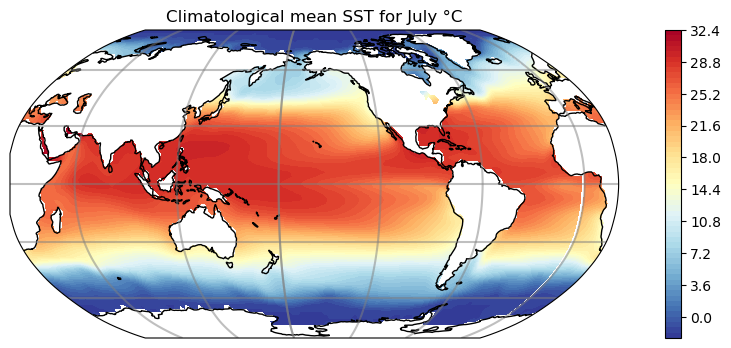

In [7]:
# let's try to plot a monthly mean

# Plot 1 - January
if True:
    # make figure
    plt.figure(figsize=(12, 4), dpi=100)
    # Set up projection
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
    # plot data
    plt.contourf(lon, lat, sstm[0,:,:], 60, cmap = col_mapc,
             transform=ccrs.PlateCarree())
    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
    # housekeeping
    ax.coastlines()
    plt.colorbar()
    plt.title('Climatological mean SST for January \N{DEGREE SIGN}C')
    plt.show()


# PLOT 2 - July
if True:
    # make figure
    plt.figure(figsize=(12, 4), dpi=100)
    # Set up projection
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
    # plot data
    plt.contourf(lon, lat, sstm[6,:,:], 60, cmap = col_mapc,
             transform=ccrs.PlateCarree())
    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
    # housekeeping
    ax.coastlines()
    plt.colorbar()
    plt.title('Climatological mean SST for July \N{DEGREE SIGN}C')
    plt.show()

## Pick subset of months / reigon for EOF Analysis

In [8]:
#  Specify the geographical boundaries and months we want to use
# let's experiment a bit with the xarray version
#sst  # this statement tells you what is in the structure sst 
#ssta = sst.sel(time=slice(1950-1-1, 2022-1-1),lon=slice(0., 90.),lat=slice(0., 89.))


# Specify year range, print for user confirmation
yr1= str(yra)+'-01-01'
yr2= str(yrb)+'-12-31'
years = np.linspace(float(yra),float(yrb+1),num = (yrb-yra+1)*12)
print('size years',np.shape(years),yr1,yr2)

# select all data
sst0 = sst.sel(time=slice(yr1, yr2),lat=slice(90., -90),lon=slice(0., 360.))

# select data in specified range
ssta = sst.sel(time=slice(yr1, yr2),lat=slice(lat1, lat2),lon=slice(lon1, lon2))

# make arrays of lat and lon
lat_sh=ssta.lat
lon_sh=ssta.lon

size years (888,) 1950-01-01 2023-12-31


## Remove Global Mean. Weight by sqrt(cosine(latitude)) so area variance is used in EOF computation

Weighting Complete


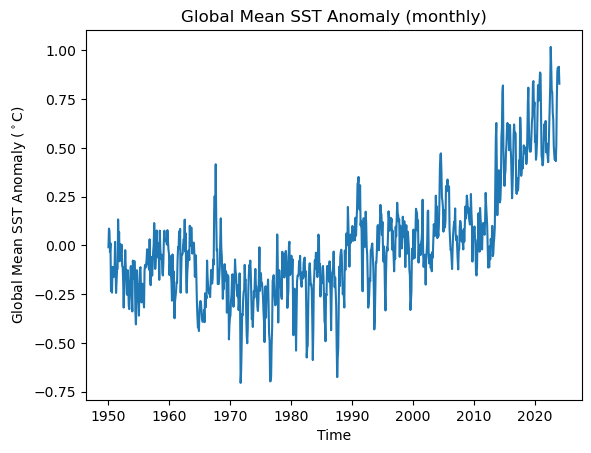

In [9]:
# function removes global mean anomaly from ss
def globalmean(sst,cn,num_years,lat_sh):  # I have not finished or implemented removing the global mean from each month.
    
    for i in range(num_years):
        
        for j in range(len(lat_sh)):
            sst[i,j,:] = sst[i,j,:]*cn[j]  # times sqrt(cos(lat))
            
    gm = nanmean(sst,1)
    gm = nanmean(gm,1)
    return gm


# make vector for weigting the data array for sqrt(cosine(latitude)) so area variance is used in EOF computation
cn = np.sqrt(np.cos(lat_sh*np.pi/180.))

# Apply weighting vector (for use in calculating the global mean)
ssta_weighted = ssta * 0
for i in range(len(lat_sh)):
    # multiply all entries in this row by the weight in the weights vector (cn)
    ssta_weighted[:,i,:] = ssta[:,i,:]*cn[i]  # times sqrt(cos(lat))
print("Weighting Complete")
    
# calculate global mean anomaly
gm = []
for i in range(len(years)):
    gm.append(np.nanmean(ssta_weighted[i,:,:]))

# Apply global mean / area weighting
if rem_globmean:
    
    # first remove global mean
    for i in range(len(years)):
        ssta[i,:,:] = ssta[i,:,:] - gm[i]

    # next apply latitude weighting
    for i in range(len(lat_sh)):
    # multiply all entries in this row by the weight in the weights vector (cn)
        ssta[:,i,:] = ssta[:,i,:]*cn[i]  # times sqrt(cos(lat))

else:
    # if we aren't removing global mean, we still need to apply latitude weighting
    ssta = ssta_weighted
    
# plot global mean anomaly
if True:
    fig,axs = plt.subplots()
    axs.set_ylabel('Global Mean SST Anomaly ($^\circ$C)')
    axs.set_xlabel('Time')
    axs.set_title('Global Mean SST Anomaly (monthly)')
    axs.plot(years,gm)

## Test plot to make sure  all is working


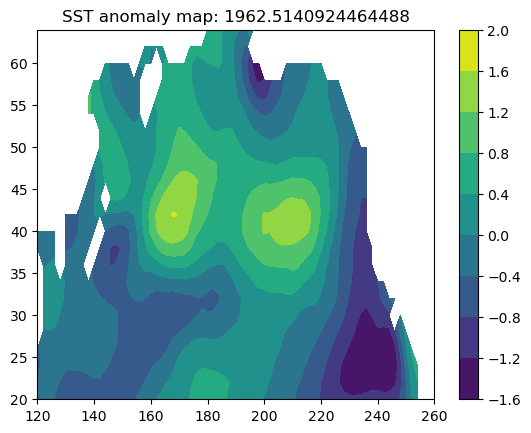

In [10]:
if True:

    # pick arbitrary month
    i = 150

    # Plot
    plt.figure()
    plt.contourf(lon_sh,lat_sh,ssta[i,:,:]) 
    plt.title('SST anomaly map: '+str(years[i]))
    plt.colorbar()

## Don't apply land mask

This is where Dennis's code applies a land mask. However, that doesn't seem to be neccissary for me - it looks like the mask is already applied. I'm not totally sure how - maybe the data format has been updated to only include SSTs on the ocean?

I'll take the win. Onto the EOF analysis.

## Arange Data in a form useful for EOF Analysis

We need an array that is 2-D with all the data points in one direction and all the months in another

In [11]:
# set mnx, which defines the number of timesteps
mnx = len(years)

# Convert to numpy
sstx = xr.DataArray.to_numpy(ssta)
sstx[np.isnan(sstx)] = 0.0

# convert into format for xarray
sstx = np.reshape(sstx,(mnx,sstx.shape[1]*sstx.shape[2]))


## Now we can check autocorrelation and estimate decrees of freedom.

In [12]:
# Ok, now I think we have an array sstz that is [months,space]  Where only land regions are kept
# First let's estimate the number of degrees of freedom in the sample by estimating a grand autocorrelation
def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.nanmean(x)
    var=np.nanvar(x)
    if var == 0.0:
        var=1.0e-6
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    #corr=[ np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
xcor = np.zeros([2])

nt, ns = np.shape(sstx)
print('nt',nt,'ns',ns)
type(ns)

lags = [0,1]
for i in range(ns):
    xx=np.squeeze(sstx[:,i])
    xcor1 = autocorr2(xx,lags)
    xcor = xcor + xcor1

print('xx',xx[0:4],xx[-4:])    
xcor = xcor/float(ns)
print('xcor ',xcor)
acorr = xcor[1]
dof_sst = mnx*(1. - acorr**2)/(1. + acorr**2)
print('DOF = ',dof_sst,',   DOF/mnx = ',dof_sst/mnx,',  mnx = ',mnx)

nt 888 ns 1633
xx [0. 0. 0. 0.] [0. 0. 0. 0.]
xcor  [1.         0.51965173]
DOF =  510.38344059862305 ,   DOF/mnx =  0.5747561268002512 ,  mnx =  888


## Finally - we can attempt EOF analysis

We're starting this step with sst x, which is lax times lon wide and monthstimes years tall

In [13]:
# check the shape again
print('sstx shape ',np.shape(sstx))

# do some matrix math!
mmax = np.max(sstx)
print('mmax ',mmax)
u, s, vh = np.linalg.svd(sstx.T)
print('u shape',np.shape(u))

sstx shape  (888, 1633)
mmax  7.2313037
u shape (1633, 1633)


## Plot Eigenvalues of EOF / Princial Component Timeseries

u shape (1633, 1633)
vh shape (888, 888)
s shape (888,)


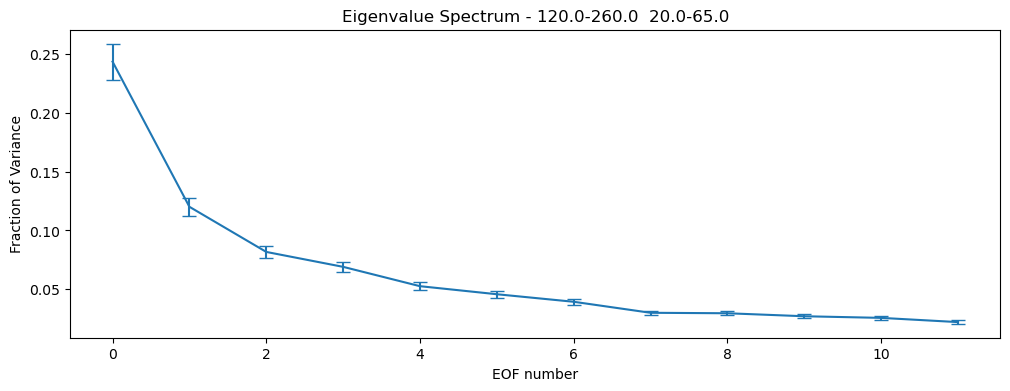

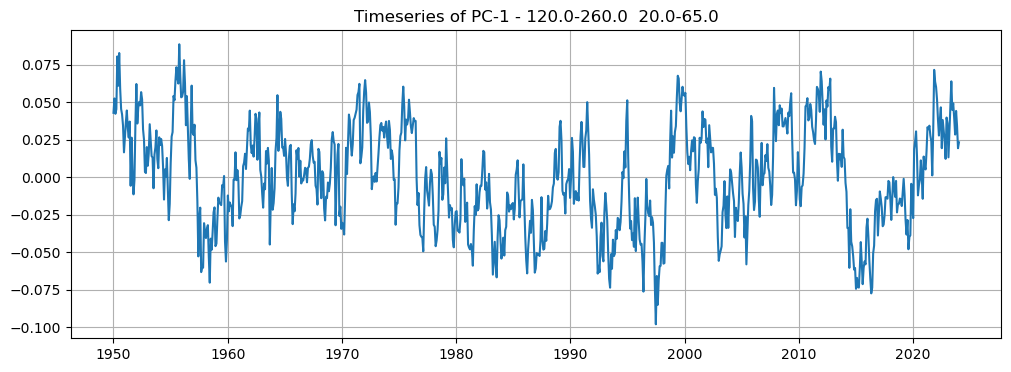

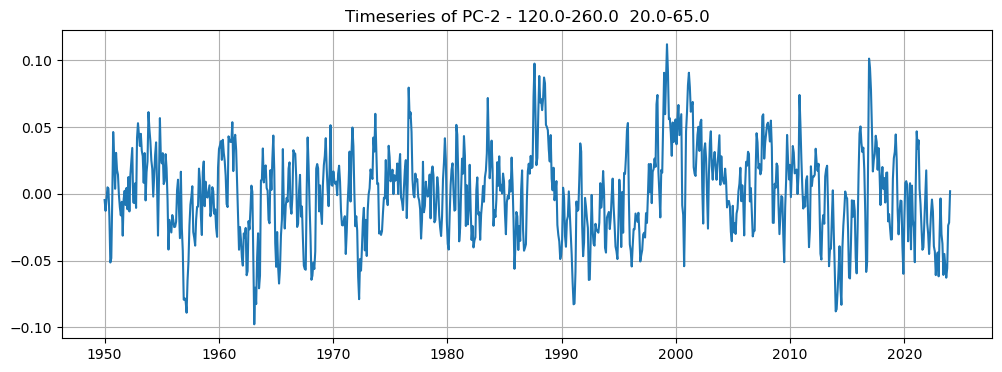

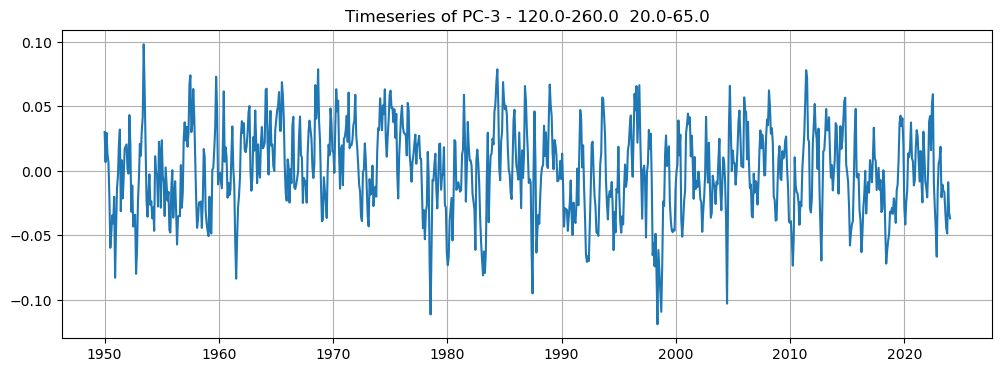

In [14]:
print('u shape',np.shape(u))
print('vh shape',np.shape(vh))
print('s shape',np.shape(s))
type(u)
type(vh)
type(s)
spectrum = s*s.T
spectrum = spectrum/sum(spectrum)
plt.figure(figsize=(12, 4), dpi=100)
yerror = spectrum*np.sqrt(2/dof_sst)
index = np.linspace(0,24,25)
    
plt.errorbar(index[0:12],spectrum[0:12],yerror[0:12],capsize=5)
plt.ylabel('Fraction of Variance')
plt.xlabel('EOF number')
plt.title('Eigenvalue Spectrum - ' + str(lon1) + '-' + str(lon2) + '  ' + str(lat2) +'-' \
              + str(lat1)  )       
#  We need to construct the EOF map by regressing the pc onto the original data
pcmx=3  # were going to consider the first 4 eofs

ts = vh[0:pcmx,:]  # hope this is time series of first eof, YES looks right, has autocorrelation

for pci in range(0,pcmx):

    plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(years,ts[pci,:])
    plt.title('Timeseries of PC-' + str(pci+1) +' - ' + str(lon1) + '-' + str(lon2) + '  ' + str(lat2) +'-' \
              + str(lat1)  )
    plt.grid()


## Regress onto the orignal Data

In [15]:
# here we attempt the regression:  we need to go back and get the original data
regm = np.empty([pcmx+1,latx*lonx])
for pci in range(0,3):
    t=ts[pci,:]
    t = t/np.std(t)  # normalize predictor to have one standard deviation
    sstb = xr.DataArray.to_numpy(sst0)
    sstb=np.reshape(sstb,(mnx,latx*lonx))
    print('shape sstb ',np.shape(sstb))
    reg = np.matmul(t,sstb)/mnx
    print('shape reg ',np.shape(reg))
    #regm[pci,:] = np.reshape(reg,(latx,lonx))
    regm[pci,:] = reg
    print('shape regn ',np.shape(regm))
regm = np.reshape(regm,(pcmx+1,latx,lonx))  # reshape for plotting    


shape sstb  (888, 16020)
shape reg  (16020,)
shape regn  (4, 16020)
shape sstb  (888, 16020)
shape reg  (16020,)
shape regn  (4, 16020)
shape sstb  (888, 16020)
shape reg  (16020,)
shape regn  (4, 16020)


## Plot regressions

,  rmax  0.6039572358131409  -  0.6039572358131409


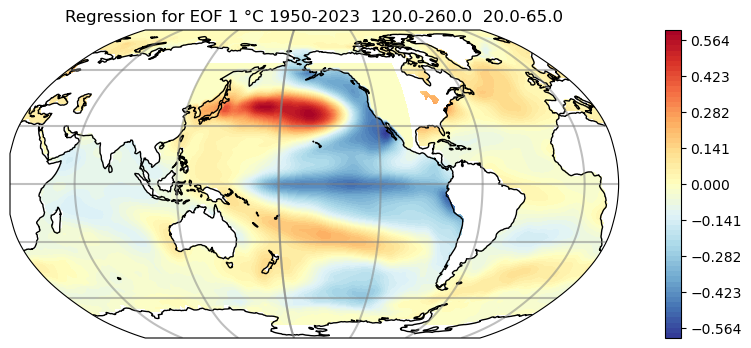

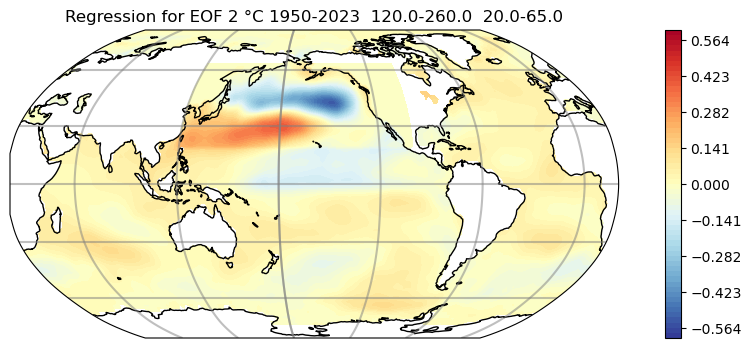

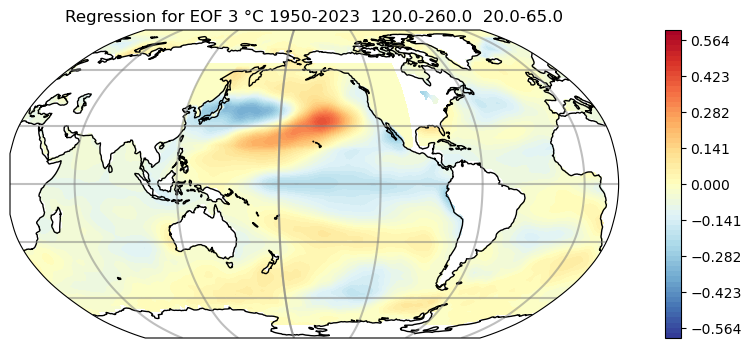

In [16]:
# contour plot some regressions
mnames = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
#col_map = 'coolwarm'
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu_r'
for ip in range(0,pcmx):
    regm1 = regm[ip,:,:]
    # here I am finding the maximum value, then I will fix the contours and colorbar to be constant across months

    if ip == 0:  # same contour interval for all plots
        rmax = np.nanmax(np.abs(regm1))
        nconts=60
        contr = np.linspace(-rmax,rmax,nconts+1)
        print(',  rmax ',rmax, ' - ',np.max(contr))

    # toggle True/False to plot maps of regressions
    if True:
        # here we extend the array by one, so there is no gap in the contours
        prcpmp = np.empty([latx,lonx+1])  
        prcpm=regm1
        prcpmp[:,0:len(lon)]= prcpm
        prcpmp[:,len(lon+1)]= prcpm[:,0]
        plt.figure(figsize=(12, 4), dpi=100)
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))

        #plt.contourf(lon, lat, rp[i,:,:], contr, cmap=col_mapr,
        plt.contourf(lonp, lat, prcpmp, contr, cmap=col_mapr,
             transform=ccrs.PlateCarree())
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
        ax.coastlines()
        plt.colorbar()
        #plt.clim(contr[0],contr[nconts-1])
        #plt.title('Regression for ' + mnames[i] + ' \N{DEGREE SIGN}C')
        plt.title('Regression for EOF ' + str(ip+1) + ' \N{DEGREE SIGN}C ' + str(yra) + '-' + str(yrb) + '  ' + str(lon1) + '-' + str(lon2) + '  ' + str(lat2) +'-' \
              + str(lat1) )
        #plt.colorbar(location='bottom')
        plt.show()
